In [1]:
from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

In [2]:
import os
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./data/gender_submission.csv
./data/train.csv
./data/test.csv


## Load train and test file with pandas

In [3]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [4]:
full = [train, test]

## Visualizing data

In [5]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


### Dataset visualization and statistics

In [6]:
#Let's see the amount of survived for each class. That can be done easily with pandas and its groupby method
PclassRatio = train[['Pclass', 'Survived']].groupby(['Pclass']).mean()
print(PclassRatio)

        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363


In [7]:
SexRatio = train[['Sex', 'Survived']].groupby(['Sex']).mean()
print(SexRatio)

        Survived
Sex             
female  0.742038
male    0.188908


In [8]:
for dataset in full:
    #Start creating new features for both dataset train and test
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

FamilySizeRatio = train[['FamilySize', 'Survived']].groupby(['FamilySize']).mean()
print(FamilySizeRatio)
# FamilySizeRatio.plot.barh()

            Survived
FamilySize          
1           0.303538
2           0.552795
3           0.578431
4           0.724138
5           0.200000
6           0.136364
7           0.333333
8           0.000000
11          0.000000


In [9]:
for dataset in full:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['QuartileFare'] = pd.qcut(train['Fare'],4)
train['DecilesFare'] = pd.qcut(train['Fare'], 10)

QuartileFareRatio = train[['QuartileFare', 'Survived']].groupby(['QuartileFare']).mean()
# DecilesFareRatio = train[['DecilesFare', 'Survived']].groupby(['DecilesFare']).mean()
print('Quartiles Fare \n {} \n'.format(QuartileFareRatio))
# print('Deciles Fare \n {}\n'.format(DecilesFareRatio))


Quartiles Fare 
                  Survived
QuartileFare             
(-0.001, 7.91]   0.197309
(7.91, 14.454]   0.303571
(14.454, 31.0]   0.454955
(31.0, 512.329]  0.581081 



In [10]:
#Missing value age
train['Age'].isna().sum()

177

### One can decide to compute the mean and the standard deviation wit the exisisting values and then fill the missing values with a random extraction under the gaussian

In [11]:
for dataset in full:
    mean_age = dataset['Age'].mean()
    std_age = dataset['Age'].std()
    nan_age = dataset['Age'].isnull().sum()
    
    random_age = np.random.randint(low = mean_age - std_age, high = mean_age + std_age, size = nan_age)
    
    dataset['Age'].loc[dataset['Age'].isna() == True] = random_age
    dataset['Age'] = dataset['Age'].astype(int)
#     print(dataset['Age'])
# We can divide the age in different ranges
# train['CategoricalAge'] = pd.qcut(train['Age'], 4)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# print(train['CategoricalAge'])
CategoricalAgeRatio = train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge']).mean()
print(CategoricalAgeRatio)


                Survived
CategoricalAge          
(-0.08, 16.0]   0.500000
(16.0, 32.0]    0.350562
(32.0, 48.0]    0.389764
(48.0, 64.0]    0.434783
(64.0, 80.0]    0.090909


/home/wahid/Programs/pyenvs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,QuartileFare,DecilesFare,CategoricalAge
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,2,"(-0.001, 7.91]","(-0.001, 7.55]","(16.0, 32.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,2,"(31.0, 512.329]","(39.688, 77.958]","(32.0, 48.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,1,"(7.91, 14.454]","(7.854, 8.05]","(16.0, 32.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,2,"(31.0, 512.329]","(39.688, 77.958]","(32.0, 48.0]"
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1,"(7.91, 14.454]","(7.854, 8.05]","(32.0, 48.0]"


# Data cleaning
### Mapping features in categorical variables and drop features that will be useless for the training


In [13]:
for dataset in full:
    
    #Sex to binary features
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1})
    
    
    #Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2})
    
    #Fare
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']    = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    #Age
    dataset.loc[ dataset['Age'] <= 16, 'Age']      = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']  
    
    
    
    
    

In [14]:
drop_elements = ['PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Name']

train_clean = train.drop(drop_elements, axis = 1)
train = train_clean.drop(['QuartileFare', 'DecilesFare', 'CategoricalAge'], axis = 1)

test_clean = test.drop(drop_elements, axis = 1)
test = test_clean

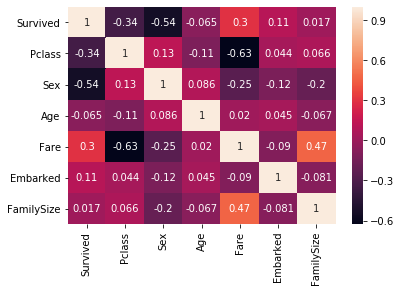

In [15]:
sns.heatmap(train.corr(), annot = True)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = ((train.iloc[:, 1:]).values).astype(int)
y = ((train.iloc[:, 0]).values).astype(int)

acc_dict = {}

for train_index, test_index in sss.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc
            
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns = log_cols)
    log = log.append(log_entry)



/home/wahid/Programs/pyenvs/py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/wahid/Programs/pyenvs/py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:715: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/wahid/Programs/pyenvs/py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:715: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/wahid/Programs/pyenvs/py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:718: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/home/wahid/Programs/pyenvs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_ite

/home/wahid/Programs/pyenvs/py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/wahid/Programs/pyenvs/py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:715: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/wahid/Programs/pyenvs/py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:715: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/wahid/Programs/pyenvs/py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:718: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/home/wahid/Programs/pyenvs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_ite

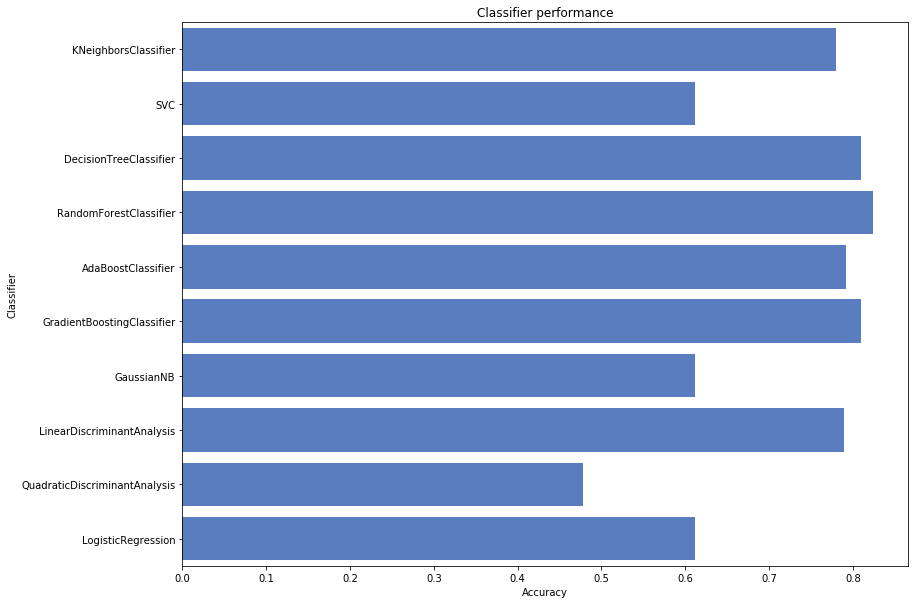

In [17]:
fig = plt.figure(figsize = (13,10))
plt.xlabel('Accuracy')
plt.title('Classifier performance')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [18]:
classifier = RandomForestClassifier()
train = (train.values).astype(int)
test = (test.values).astype(int)
classifier.fit(train[:,1:], train[:, 0])
result = classifier.predict(test)

In [27]:
d = {"PassengerId": full[1].PassengerId, "Survived": result}
submit = pd.DataFrame(d)
submit = submit.set_index('PassengerId')
submit.to_csv('./output/submission.csv')

In [28]:
submit

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


/home/wahid/Wahid/University/Other/MLCheatSheet/Kaggle/titanic
